<a href="https://colab.research.google.com/github/MaayanHagbi/CAS_ADS_Final_Project/blob/main/Fraud_Detection_ML_(CAS_ADS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Packages

In [19]:
#Google Big Query related packages
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
!pip install geoip2
import geoip2.database
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive
drive.mount('/content/drive')
#Clone Repository
!git clone https://github.com/MaayanHagbi/CAS_ADS_Final_Project

#ML Packages
from sklearn.preprocessing import RobustScaler

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'CAS_ADS_Final_Project' already exists and is not an empty directory.


#Authenticate Google Big Query Access

In [20]:
auth.authenticate_user()
print('Authenticated')

Authenticated


##Connect to Big Query and Get Data

In [21]:
project_id = 'total-biplane-387513'
bigquery_client = bigquery.Client(project = project_id)

Query = "SELECT * FROM `total-biplane-387513.Data_Sceince_Project_Dataset.CAS_ADS_Dataset` limit 10000;"
Query_Results = bigquery_client.query(Query)
df = Query_Results.to_dataframe()
df

#Copy Dataset
Data_Adf = df.copy()

#Account for Null Values
Data_Adf.replace('<NA>', np.nan, inplace=True)

In [22]:
def convert_float(columns):
  for col in columns:
    Data_Adf[col] = pd.to_numeric(Data_Adf[col],errors='coerce')

def convert_string(columns):
  for col in columns:
    Data_Adf[col] = Data_Adf[col].astype(str)

columns_to_string = ['id']
columns_to_float = ['amount_gbp']

convert_float(columns_to_float)
convert_string(columns_to_string)



#Add Is_fraud Column
Data_Adf['Is_fraud'] = Data_Adf['Chargebackreason_id'].notnull()


#Data Analysis

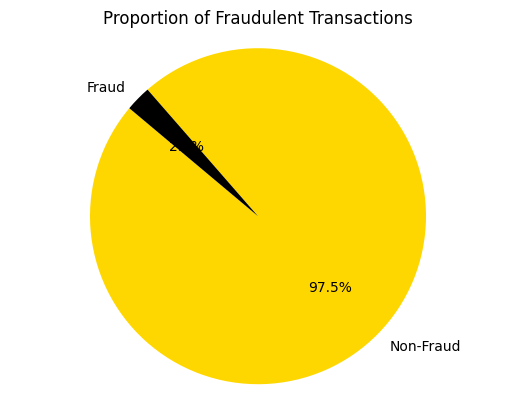

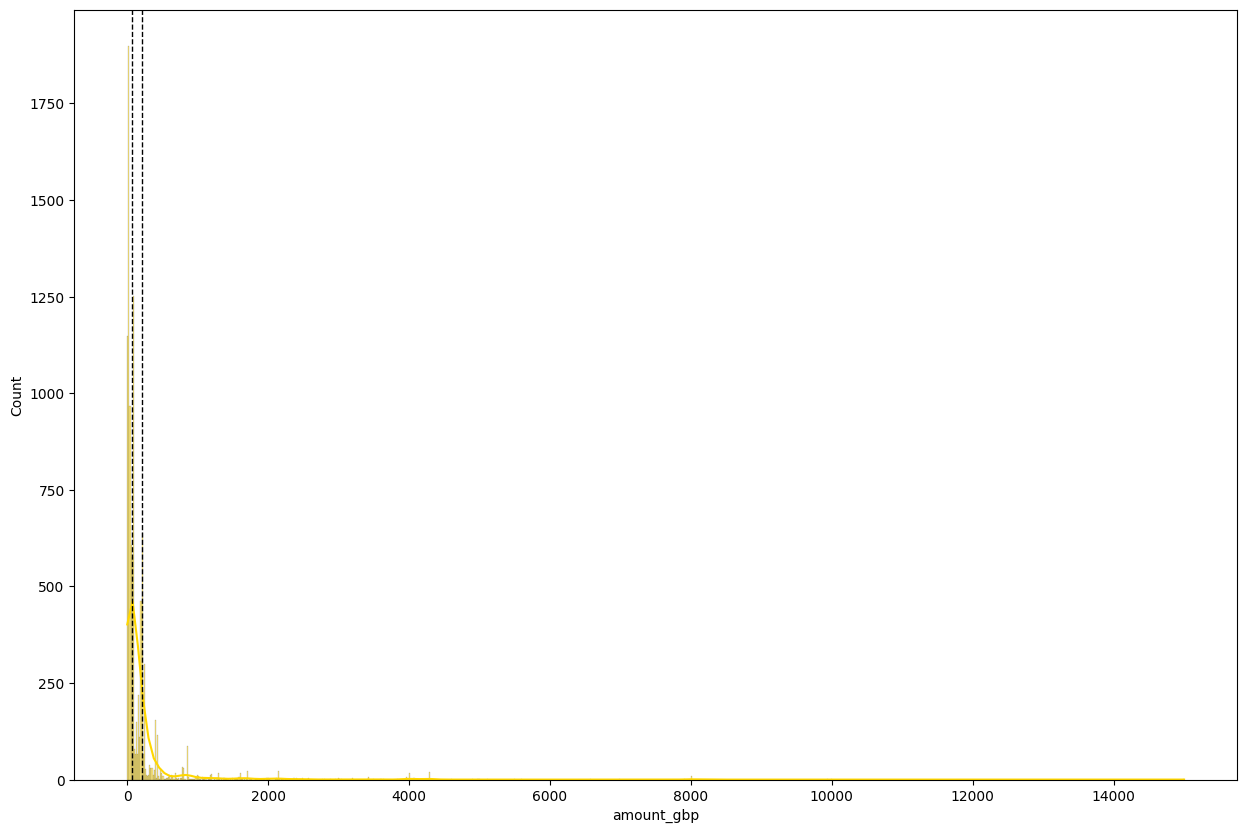

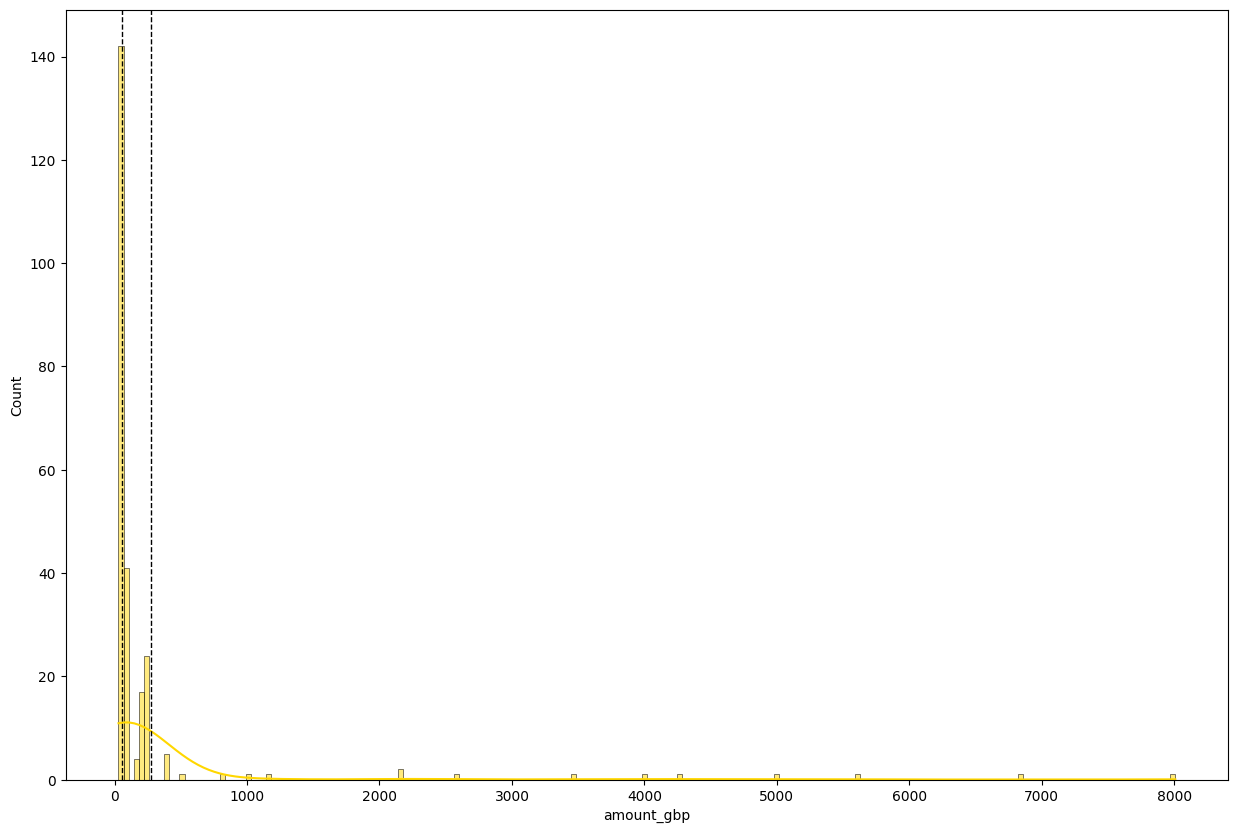

In [23]:
#Look into share of fradulent trx vs non-fraudulent
Data_Adf["Is_fraud"].value_counts().plot.pie(labels=['Non-Fraud','Fraud'],colors=['gold','black'], autopct='%1.1f%%',startangle=140,textprops={'color':"black"})
plt.title('Proportion of Fraudulent Transactions')
plt.ylabel('')
plt.axis('equal')
plt.show()

#Check Amount distribution of Fraudulent Vs non Fraudulent Trx
fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==True]
non_fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==False]

#Trx_amount_gbp
plt.figure(figsize=(15,10))
sns.histplot(non_fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black')
mean_value = np.mean(non_fraudulent_df["amount_gbp"])
median_value = np.median(non_fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1)
plt.axvline(median_value, color='black', linestyle='dashed', linewidth=1)
plt.show()


plt.figure(figsize=(15,10))
sns.histplot(fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black')
mean_value = np.mean(fraudulent_df["amount_gbp"])
median_value = np.median(fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1)
plt.axvline(median_value, color='black', linestyle='dashed', linewidth=1)
plt.show()

#Generate Customer Profiles (Cust_Profiles)

In [24]:
#Calcualte Customer Profile Statistics
cust_profiles = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].agg(['mean','median']).reset_index()
cust_profiles.columns = ['client_id','cust_profiles_mean_gbp_amount','cust_profiles_median_gbp_amount']
cust_profiles_std = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].std(ddof=0).reset_index()
cust_profiles_std.columns = ['client_id','cust_profiles_std_gbp_amount']


#Calcualte Average Number of Trx
Data_Adf['timestamp'] = pd.to_datetime(Data_Adf['timestamp'],errors='coerce')
trx_per_day_per_customer = Data_Adf.groupby(['Clientinfo_id', Data_Adf['timestamp'].dt.date]).size().reset_index(name='num_transactions')
mean_nb_trx_per_day = trx_per_day_per_customer.groupby('Clientinfo_id')['num_transactions'].mean().reset_index()
mean_nb_trx_per_day.columns = ['client_id','cust_profiles_mean_nb_trx_per_day']

#Merge Datasets to one
Cust_Profiles = pd.merge(cust_profiles,cust_profiles_std,on='client_id')
Cust_Profiles = pd.merge(cust_profiles,mean_nb_trx_per_day,on='client_id')

#Cust_Profiles_Data
Cust_Profiles

,client_id,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,1058596,237.83,237.83,1.0
1,1058603,237.83,237.83,1.0
2,1059069,237.83,237.83,1.0
3,1059483,37.64,37.64,1.0
4,1059488,37.64,37.64,1.0
...,...,...,...,...
9296,4640468,427.00,427.00,1.0
9297,4640839,400.33,400.33,1.0
9298,4640970,380.31,380.31,1.0
9299,4641469,52.11,52.11,1.0


# Get Customer Country from IP Address / Card Info (Cust_Country_Profile)

In [26]:
def get_country(ip):
    mmdb_file_path = '/content/drive/MyDrive/Colab_Notebooks/CAS_Final_Project/GeoLite2-City.mmdb'

    if pd.notna(ip) and ip != 'nan':
        try:
            with geoip2.database.Reader(mmdb_file_path) as reader:
                response = reader.city(ip)

                country_name = response.country.name
                country_iso_code = response.country.iso_code
                return country_name, country_iso_code
        except Exception as e:
            return 0, 0
    else:
        return 0, 0

df_Country_lan_lat = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/CAS_Final_Project/Country_lan_lat.csv",sep=';')



#Get Customer Device IP Coordinates (Country)
Cust_Country_Profile_Ip = Data_Adf[['id','Clientinfo_id','Deviceinfo_ip']].copy()
Cust_Country_Profile_Ip['Deviceinfo_ip'] = Cust_Country_Profile_Ip['Deviceinfo_ip'].astype(str)
Cust_Country_Profile_Ip[['country_name','country']] = Cust_Country_Profile_Ip['Deviceinfo_ip'].apply(lambda x:  pd.Series(get_country(x)))

merge_df = pd.merge(Cust_Country_Profile_Ip,df_Country_lan_lat,on='country',how='left')

columns_to_keep = ['id','Clientinfo_id','latitude','longitude']
Cust_Country_Profile_Ip = merge_df[columns_to_keep]

old_colums_names = ['id','Clientinfo_id','latitude','longitude']
new_columns_names = ['id','client_id','latitude_ip','longitude_ip']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Cust_Country_Profile_Ip = Cust_Country_Profile_Ip.rename(columns=new_columns_dic)
Cust_Country_Profile_Ip

#Get Customer Card Issuer Bank Coordinates (Country)
Card_Info_Country_Profile = Data_Adf[['id','Clientinfo_id','Countries_iso2']].copy()
old_colums_names = ['Countries_iso2']
new_columns_names = ['country']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Card_Info_Country_Profile = Card_Info_Country_Profile.rename(columns=new_columns_dic)
merge_df = pd.merge(Card_Info_Country_Profile,df_Country_lan_lat,on='country',how='left')
columns_to_keep = ['id','Clientinfo_id','latitude','longitude']
Card_Info_Country_Profile = merge_df[columns_to_keep]
old_colums_names = ['id','Clientinfo_id','latitude','longitude']
new_columns_names = ['id','client_id','latitude_card','longitude_card']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Card_Info_Country_Profile = Card_Info_Country_Profile.rename(columns=new_columns_dic)
Card_Info_Country_Profile


#Customer Country Coordinates (Final)
merge_df = pd.merge(Cust_Country_Profile_Ip,Card_Info_Country_Profile,on='id')
merge_df.columns
columns_to_keep = ['id', 'client_id_x', 'latitude_ip', 'longitude_ip','latitude_card', 'longitude_card']
Cust_Country_Profile = merge_df[columns_to_keep]
Cust_Country_Profile.columns


old_colums_names = ['id', 'client_id_x', 'latitude_ip', 'longitude_ip', 'latitude_card','longitude_card']
new_columns_names = ['id', 'client_id', 'latitude_ip', 'longitude_ip', 'latitude_card','longitude_card']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Cust_Country_Profile = Cust_Country_Profile.rename(columns=new_columns_dic)

Cust_Country_Profile.set_index('id',inplace=True)
Cust_Country_Profile.index = Cust_Country_Profile.index.astype(int)
Cust_Country_Profile

,client_id,latitude_ip,longitude_ip,latitude_card,longitude_card
id,,,,,
11329169,4537345,48.019573,66.923684,38.963745,35.243322
11405291,4569884,56.879635,24.603189,38.963745,35.243322
11391001,4563976,48.019573,66.923684,38.963745,35.243322
11391561,4564234,56.879635,24.603189,38.963745,35.243322
11499681,4607984,48.019573,66.923684,38.963745,35.243322
...,...,...,...,...,...
2732408,1444598,NaN,NaN,-22.957640,18.490410
2565055,1371468,NaN,NaN,-22.957640,18.490410
3113591,1590762,NaN,NaN,-22.957640,18.490410


# Get Transaction Profile (Trx_Profile)

In [27]:
def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

def is_weekend(date):
    return date.weekday() >= 5

def get_client_spending_behaviour_features(customer_trx, window_size_in_days = [1,7,30]):

  customer_trx = customer_trx.sort_values('timestamp')
  customer_trx.index = customer_trx.timestamp

  for window_size in window_size_in_days:
    sum_amount_trx_window = customer_trx['amount_gbp'].rolling(str(window_size)+'d').sum()
    nb_trx_window = customer_trx['amount_gbp'].rolling(str(window_size) + 'd').count()

    avg_amount_trx_window = sum_amount_trx_window/nb_trx_window

    customer_trx['client_nb_trx_' + str(window_size) + 'day_window'] = list(nb_trx_window)
    customer_trx['client_avg_amount_'+str(window_size) + 'day_window'] = list(avg_amount_trx_window)

  customer_trx.index = customer_trx.id

  return customer_trx

#Trx Profiles table
Trx_Profile = Data_Adf[['id','timestamp','Clientinfo_id','amount_gbp']].copy()
Trx_Profile.loc[:,'time'] = Trx_Profile['timestamp'].dt.time
Trx_Profile.loc[:,'trx_time_seconds'] = Trx_Profile['time'].apply(lambda x: time_to_seconds(x))
Trx_Profile.loc[:,'date'] = Trx_Profile['timestamp'].dt.date
Trx_Profile.loc[:,'is_WKE?'] = Trx_Profile['date'].apply(lambda x: is_weekend(x)).astype(int)

target_time = pd.to_datetime('22:00:00').time()
Trx_Profile.loc[:,'is_night?'] = (Trx_Profile['time'] > target_time).astype(int)


columns_to_drop = ['time','date']
Trx_Profile = Trx_Profile.drop(columns=columns_to_drop)
old_colums_names = Trx_Profile.columns
new_columns_names = ['id','timestamp','client_id','trx_amount_gbp','trx_time_seconds','trx_is_weekend']
new_columns_dic = {k: v for k, v in zip(old_colums_names,new_columns_names)}

Trx_Profile = Trx_Profile.rename(columns=new_columns_dic)

Trx_Profile.set_index('id',inplace=True)
Trx_Profile.index = Trx_Profile.index.astype(int)
Trx_Profile

,timestamp,client_id,trx_amount_gbp,trx_time_seconds,trx_is_weekend,is_night?
id,,,,,,
11329169,2024-04-03 10:20:20+00:00,4537345,80.07,37220,0,0
11405291,2024-04-10 14:24:21+00:00,4569884,80.07,51861,0,0
11391001,2024-04-09 10:20:04+00:00,4563976,80.07,37204,0,0
11391561,2024-04-09 11:11:38+00:00,4564234,80.07,40298,0,0
11499681,2024-04-20 14:01:26+00:00,4607984,80.07,50486,1,0
...,...,...,...,...,...,...
2732408,2021-04-28 19:59:05+00:00,1444598,37.64,71945,0,0
2565055,2021-03-31 17:06:35+00:00,1371468,37.64,61595,0,0
3113591,2021-06-30 20:45:05+00:00,1590762,155.89,74705,0,0


# Get Customer Behavoiur Profile (Trx_Profile_Rolling)

In [28]:
#Customer Behaviour Profile
Trx_Profile_Rolling = Data_Adf[['id','timestamp','Clientinfo_id','amount_gbp']].copy()

Trx_Profile_Rolling['timestamp'] = Trx_Profile_Rolling['timestamp'].dt.tz_localize(None)
Trx_Profile_Rolling['timestamp'] = Trx_Profile_Rolling['timestamp'].astype('datetime64[ns]')

Trx_Profile_Rolling = Trx_Profile_Rolling.sort_values(['timestamp','Clientinfo_id'], ascending=[True,True],ignore_index=True)

%time Trx_Profile_Rolling = Trx_Profile_Rolling.groupby('Clientinfo_id').apply(lambda x: get_client_spending_behaviour_features(x))

Trx_Profile_Rolling.set_index('id',inplace=True)
Trx_Profile_Rolling.index = Trx_Profile_Rolling.index.astype(int)
Trx_Profile_Rolling

CPU times: user 58.2 s, sys: 767 ms, total: 59 s
Wall time: 1min 2s


,timestamp,Clientinfo_id,amount_gbp,client_nb_trx_1day_window,client_avg_amount_1day_window,client_nb_trx_7day_window,client_avg_amount_7day_window,client_nb_trx_30day_window,client_avg_amount_30day_window
id,,,,,,,,,
1992735,2021-01-03 09:12:54,1058596,237.83,1.0,237.83,1.0,237.83,1.0,237.83
1983632,2021-01-01 02:41:47,1058603,237.83,1.0,237.83,1.0,237.83,1.0,237.83
1986110,2021-01-01 16:59:02,1059069,237.83,1.0,237.83,1.0,237.83,1.0,237.83
1987217,2021-01-01 22:22:46,1059483,37.64,1.0,37.64,1.0,37.64,1.0,37.64
1987231,2021-01-01 22:29:17,1059488,37.64,1.0,37.64,1.0,37.64,1.0,37.64
...,...,...,...,...,...,...,...,...,...
11582690,2024-04-30 09:24:47,4640468,427.00,1.0,427.00,1.0,427.00,1.0,427.00
11583816,2024-04-30 11:19:37,4640839,400.33,1.0,400.33,1.0,400.33,1.0,400.33
11584011,2024-04-30 11:39:40,4640970,380.31,1.0,380.31,1.0,380.31,1.0,380.31


# Get Merchant Brand Profile (Brand_Fraud_Profile)

In [29]:
def get_count_risk_rolling_window(terminal_trx, delay_period = 7, windows_size_in_days = [1, 7, 30], feature = "Terminal_ID"):

  terminal_trx = terminal_trx.sort_values('timestamp')
  terminal_trx.index = terminal_trx.timestamp

  for window_size in windows_size_in_days:
   sum_amount_fraud_trx_window = terminal_trx['amount_gbp_fraud_trx'].rolling(str(window_size) + 'd').sum()
   nb_fraud_trx_window = terminal_trx['amount_gbp_fraud_trx'].rolling(str(window_size) + 'd').count()

   avg_amount_fraud_trx = sum_amount_fraud_trx_window / nb_fraud_trx_window

   terminal_trx['brand_fraud_nb_trx_' + str(window_size) + 'day_window'] = list(nb_fraud_trx_window)
   terminal_trx['brand_fraud_avg_amount_'+str(window_size) + 'day_window'] = list(avg_amount_fraud_trx)

  terminal_trx.index = terminal_trx.id

  return terminal_trx

Data_Adf['Is_fraud'] = Data_Adf['Is_fraud'].astype(bool)
Data_Adf['amount_gbp_fraud_trx'] = Data_Adf['amount_gbp'].where(Data_Adf['Is_fraud'], np.nan)

Brand_Fraud_Profile = Data_Adf[['id','timestamp','Brands_id','amount_gbp_fraud_trx']].copy()

Brand_Fraud_Profile['timestamp'] = Brand_Fraud_Profile['timestamp'].dt.tz_localize(None)
Brand_Fraud_Profile['timestamp'] = Brand_Fraud_Profile['timestamp'].astype('datetime64[ns]')

Brand_Fraud_Profile = Brand_Fraud_Profile.sort_values(['timestamp','Brands_id'], ascending=[True,True],ignore_index=True)

%time Brand_Fraud_Profile = Brand_Fraud_Profile.groupby('Brands_id').apply(lambda x: get_count_risk_rolling_window(x))

Brand_Fraud_Profile.set_index('id')

Brand_Fraud_Profile

Brand_Fraud_Profile.set_index('id',inplace=True)

Brand_Fraud_Profile.index = Brand_Fraud_Profile.index.astype(int)

Brand_Fraud_Profile

CPU times: user 1.12 s, sys: 13.3 ms, total: 1.14 s
Wall time: 1.14 s


,timestamp,Brands_id,amount_gbp_fraud_trx,brand_fraud_nb_trx_1day_window,brand_fraud_avg_amount_1day_window,brand_fraud_nb_trx_7day_window,brand_fraud_avg_amount_7day_window,brand_fraud_nb_trx_30day_window,brand_fraud_avg_amount_30day_window
id,,,,,,,,,
1988735,2021-01-02 15:16:14,1234,NaN,0.0,NaN,0.0,NaN,0.0,NaN
1990998,2021-01-02 23:19:39,1234,NaN,0.0,NaN,0.0,NaN,0.0,NaN
1992252,2021-01-03 06:15:17,1234,NaN,0.0,NaN,0.0,NaN,0.0,NaN
1993159,2021-01-03 12:37:37,1234,NaN,0.0,NaN,0.0,NaN,0.0,NaN
2059116,2021-01-06 06:35:13,1234,NaN,0.0,NaN,0.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...
11289072,2024-03-30 15:55:38,851563,NaN,0.0,NaN,0.0,NaN,0.0,NaN
11355721,2024-04-05 15:36:54,851563,NaN,0.0,NaN,0.0,NaN,0.0,NaN
11563808,2024-04-28 07:08:17,851569,NaN,0.0,NaN,0.0,NaN,0.0,NaN


# Get All Dummy Variables (Data_Dummies)

In [30]:
# creating a copy of the original data frame and adding a few columns
Data_Dummies = Data_Adf[['id','Currency_name','Environments_name','Brands_name','Deviceinfo_device_name','Deviceinfo_browser_name','Clientinfo_email','Paymentbrands_name','Issuers_name','Industries_name','Companies_name','Processors_name']].copy()
Data_Dummies['Email_domain'] = Data_Dummies['Clientinfo_email'].str.split('@').str[1].str.split('.').str[0]
Data_Dummies = Data_Dummies.replace(' ', '_', regex=True)

#Creating all dummy variables
Data_Dummies = pd.get_dummies(Data_Dummies,columns=['Currency_name','Environments_name','Brands_name','Deviceinfo_device_name','Deviceinfo_browser_name','Email_domain','Paymentbrands_name','Issuers_name','Industries_name','Companies_name','Processors_name'])
Data_Dummies = Data_Dummies.drop(columns='Clientinfo_email')
Data_Dummies = Data_Dummies.astype(int)

Data_Dummies.set_index('id', inplace=True)
Data_Dummies

,Currency_name_AUD,Currency_name_CAD,Currency_name_CHF,Currency_name_EUR,Currency_name_GBP,Currency_name_MYR,Currency_name_USD,Currency_name_ZAR,Environments_name_PrestaShop,Environments_name_WooCommerce,...,Companies_name_Zorafin_Investments_Ltd,Companies_name_xShop_OU,Processors_name_CCD,Processors_name_CTM,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN
id,,,,,,,,,,,,,,,,,,,,,
11329169,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11405291,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11391001,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11391561,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11499681,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2732408,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2565055,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3113591,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# Combine Everything to a Single Dataset

In [ ]:
# Rest indexs in all dataframes in preparation to merge
Cust_Profiles #Key is Client id
Cust_Country_Profile = Cust_Country_Profile.reset_index(level='id') #Key is id
Trx_Profile = Trx_Profile.reset_index(level='id') #Key is id
Trx_Profile_Rolling = Trx_Profile_Rolling.reset_index(level='id') #Key is id
Brand_Fraud_Profile = Brand_Fraud_Profile.reset_index(level='id') #Key is id
Data_Dummies = Data_Dummies.reset_index(level='id') #Key is id

In [34]:
#Merge all datasets to a single dataset
DF = pd.merge(Cust_Country_Profile, Trx_Profile, how='left', on='id')
DF1 = pd.merge(DF, Trx_Profile_Rolling,how='left',on='id')
DF2 = pd.merge(DF1, Brand_Fraud_Profile,how='left',on='id')
DF3 = pd.merge(DF2, Data_Dummies, how='left', on='id')
DF4 = pd.merge(DF3, Cust_Profiles, how='left', left_on='client_id_x', right_on='client_id')

DF_Flag = Data_Adf[['id', 'Is_fraud']]
DF_Flag['id'] = DF_Flag['id'].astype(int)
DF4 = pd.merge(DF4, DF_Flag, how='left', on='id')
DF4['Is_fraud'] = DF4['Is_fraud'].astype(int)

#Create New Dataframe
Pre_Norm_DF = DF4
#Gather columns containing Ids
column_ids = [col for col in Pre_Norm_DF.columns if '_id' in col]
#column_ids.remove('Email_domain_idtech')
column_timestamp = [col for col in Pre_Norm_DF.columns if 'timestamp' in col]
columns_amount = [col for col in Pre_Norm_DF.columns if 'amount' in col]



dropcolumns = column_ids + column_timestamp + ['id'] + ['trx_amount_gbp']

Pre_Norm_DF = Pre_Norm_DF.drop(columns = dropcolumns)
Pre_Norm_DF


<ipython-input-34-17bc0e83883b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_Flag['id'] = DF_Flag['id'].astype(int)


,latitude_ip,longitude_ip,latitude_card,longitude_card,trx_time_seconds,trx_is_weekend,is_night?,amount_gbp,client_nb_trx_1day_window,client_avg_amount_1day_window,...,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day,Is_fraud
0,48.019573,66.923684,38.963745,35.243322,37220,0,0,80.07,1.0,80.07,...,0,0,0,0,0,0,80.070,80.070,1.0,0
1,56.879635,24.603189,38.963745,35.243322,51861,0,0,80.07,1.0,80.07,...,0,0,0,0,0,0,80.070,80.070,1.0,0
2,48.019573,66.923684,38.963745,35.243322,37204,0,0,80.07,1.0,80.07,...,0,0,0,0,0,0,80.070,80.070,1.0,0
3,56.879635,24.603189,38.963745,35.243322,40298,0,0,80.07,1.0,80.07,...,0,0,0,0,0,0,80.070,80.070,1.0,0
4,48.019573,66.923684,38.963745,35.243322,50486,1,0,80.07,1.0,80.07,...,0,0,0,0,0,0,80.070,80.070,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,NaN,NaN,-22.957640,18.490410,71945,0,0,37.64,1.0,37.64,...,0,0,0,0,0,1,37.640,37.640,1.0,1
9996,NaN,NaN,-22.957640,18.490410,61595,0,0,37.64,1.0,37.64,...,0,0,0,0,0,1,37.640,37.640,1.0,0
9997,NaN,NaN,-22.957640,18.490410,74705,0,0,155.89,1.0,155.89,...,0,0,0,0,0,1,155.890,155.890,1.0,0
9998,NaN,NaN,-22.957640,18.490410,73287,0,0,37.64,1.0,37.64,...,0,0,0,0,0,1,33.635,33.635,1.0,0


# Normalize Dataframe

In [35]:
#Perform Robust Scaling as normalization method (left skewed)
scaler = RobustScaler()
Normalized_DF = pd.DataFrame(scaler.fit_transform(Pre_Norm_DF), columns=Pre_Norm_DF.columns)

In [36]:
Normalized_DF

,latitude_ip,longitude_ip,latitude_card,longitude_card,trx_time_seconds,trx_is_weekend,is_night?,amount_gbp,client_nb_trx_1day_window,client_avg_amount_1day_window,...,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day,Is_fraud
0,0.241067,1.348652,0.603834,2.568206,-0.367912,0.0,0.0,0.046783,0.0,0.047802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.045825,0.045825,0.0,0.0
1,0.479835,0.051071,0.603834,2.568206,0.166314,0.0,0.0,0.046783,0.0,0.047802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.045825,0.045825,0.0,0.0
2,0.241067,1.348652,0.603834,2.568206,-0.368496,0.0,0.0,0.046783,0.0,0.047802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.045825,0.045825,0.0,0.0
3,0.479835,0.051071,0.603834,2.568206,-0.255601,0.0,0.0,0.046783,0.0,0.047802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.045825,0.045825,0.0,0.0
4,0.241067,1.348652,0.603834,2.568206,0.116142,1.0,0.0,0.046783,0.0,0.047802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.045825,0.045825,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,NaN,NaN,-0.355202,0.000000,0.899146,0.0,0.0,-0.207380,0.0,-0.206362,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.208338,-0.208338,0.0,1.0
9996,NaN,NaN,-0.355202,0.000000,0.521492,0.0,0.0,-0.207380,0.0,-0.206362,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.208338,-0.208338,0.0,0.0
9997,NaN,NaN,-0.355202,0.000000,0.999854,0.0,0.0,0.500958,0.0,0.501977,...,0.0,0.0,0.0,0.0,0.0,1.0,0.500000,0.500000,0.0,0.0
9998,NaN,NaN,-0.355202,0.000000,0.948114,0.0,0.0,-0.207380,0.0,-0.206362,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.232329,-0.232329,0.0,0.0


In [39]:
# Extract target variable and drop unnecessary columns
y = Normalized_DF['Is_fraud']
X = Normalized_DF.drop(columns=['Is_fraud'])

In [46]:
X = X.fillna(0)

In [47]:
X

,latitude_ip,longitude_ip,latitude_card,longitude_card,trx_time_seconds,trx_is_weekend,is_night?,amount_gbp,client_nb_trx_1day_window,client_avg_amount_1day_window,...,Processors_name_CTM,Processors_name_ECP,Processors_name_LPB,Processors_name_NUV,Processors_name_PNC,Processors_name_TRU,Processors_name_WLN,cust_profiles_mean_gbp_amount,cust_profiles_median_gbp_amount,cust_profiles_mean_nb_trx_per_day
0,0.241067,1.348652,0.603834,2.568206,-0.367912,0.0,0.0,0.046783,0.0,0.047802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045825,0.045825,0.0
1,0.479835,0.051071,0.603834,2.568206,0.166314,0.0,0.0,0.046783,0.0,0.047802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045825,0.045825,0.0
2,0.241067,1.348652,0.603834,2.568206,-0.368496,0.0,0.0,0.046783,0.0,0.047802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045825,0.045825,0.0
3,0.479835,0.051071,0.603834,2.568206,-0.255601,0.0,0.0,0.046783,0.0,0.047802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045825,0.045825,0.0
4,0.241067,1.348652,0.603834,2.568206,0.116142,1.0,0.0,0.046783,0.0,0.047802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045825,0.045825,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000000,0.000000,-0.355202,0.000000,0.899146,0.0,0.0,-0.207380,0.0,-0.206362,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.208338,-0.208338,0.0
9996,0.000000,0.000000,-0.355202,0.000000,0.521492,0.0,0.0,-0.207380,0.0,-0.206362,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.208338,-0.208338,0.0
9997,0.000000,0.000000,-0.355202,0.000000,0.999854,0.0,0.0,0.500958,0.0,0.501977,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.500000,0.500000,0.0
9998,0.000000,0.000000,-0.355202,0.000000,0.948114,0.0,0.0,-0.207380,0.0,-0.206362,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.232329,-0.232329,0.0


# Perform PCA

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [48]:
# Step 6: Principal Component Analysis (PCA)
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca = pca.fit_transform(X)

In [49]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1943    0]
 [  50    7]]
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99      1943
         1.0       1.00      0.12      0.22        57

    accuracy                           0.97      2000
   macro avg       0.99      0.56      0.60      2000
weighted avg       0.98      0.97      0.97      2000



In [50]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train a machine learning model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1943    0]
 [  26   31]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1943
         1.0       1.00      0.54      0.70        57

    accuracy                           0.99      2000
   macro avg       0.99      0.77      0.85      2000
weighted avg       0.99      0.99      0.99      2000



In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Feature scaling
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Predict on the test set
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Epoch 1/10
200/200 [==============================] - 4s 9ms/step - loss: 0.1166 - accuracy: 0.9758 - val_loss: 0.0599 - val_accuracy: 0.9800
Epoch 2/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0655 - accuracy: 0.9802 - val_loss: 0.0531 - val_accuracy: 0.9819
Epoch 3/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0580 - accuracy: 0.9816 - val_loss: 0.0477 - val_accuracy: 0.9862
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0540 - accuracy: 0.9814 - val_loss: 0.0462 - val_accuracy: 0.9862
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0502 - accuracy: 0.9827 - val_loss: 0.0415 - val_accuracy: 0.9862
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0468 - accuracy: 0.9830 - val_loss: 0.0394 - val_accuracy: 0.9869
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0447 - accuracy: 0.9828 - val_loss: 0.0375 - val_accuracy: 0.9862
Epoc